## Perfiles de densidad sup, metalicidad y z_50, GAS y ESTRELLAS

In [4]:
import numpy as np

nb = 24

delta = (13.8-0.)/nb
rango = np.arange(0,13.8,delta)

data = np.loadtxt('../_data/time.dat')
s = data[:,0]
rango_gas = np.arange(0,len(s),4)

print(len(rango), len(rango_gas))

24 24


Den sup estrellas

subhalo_127000000000002


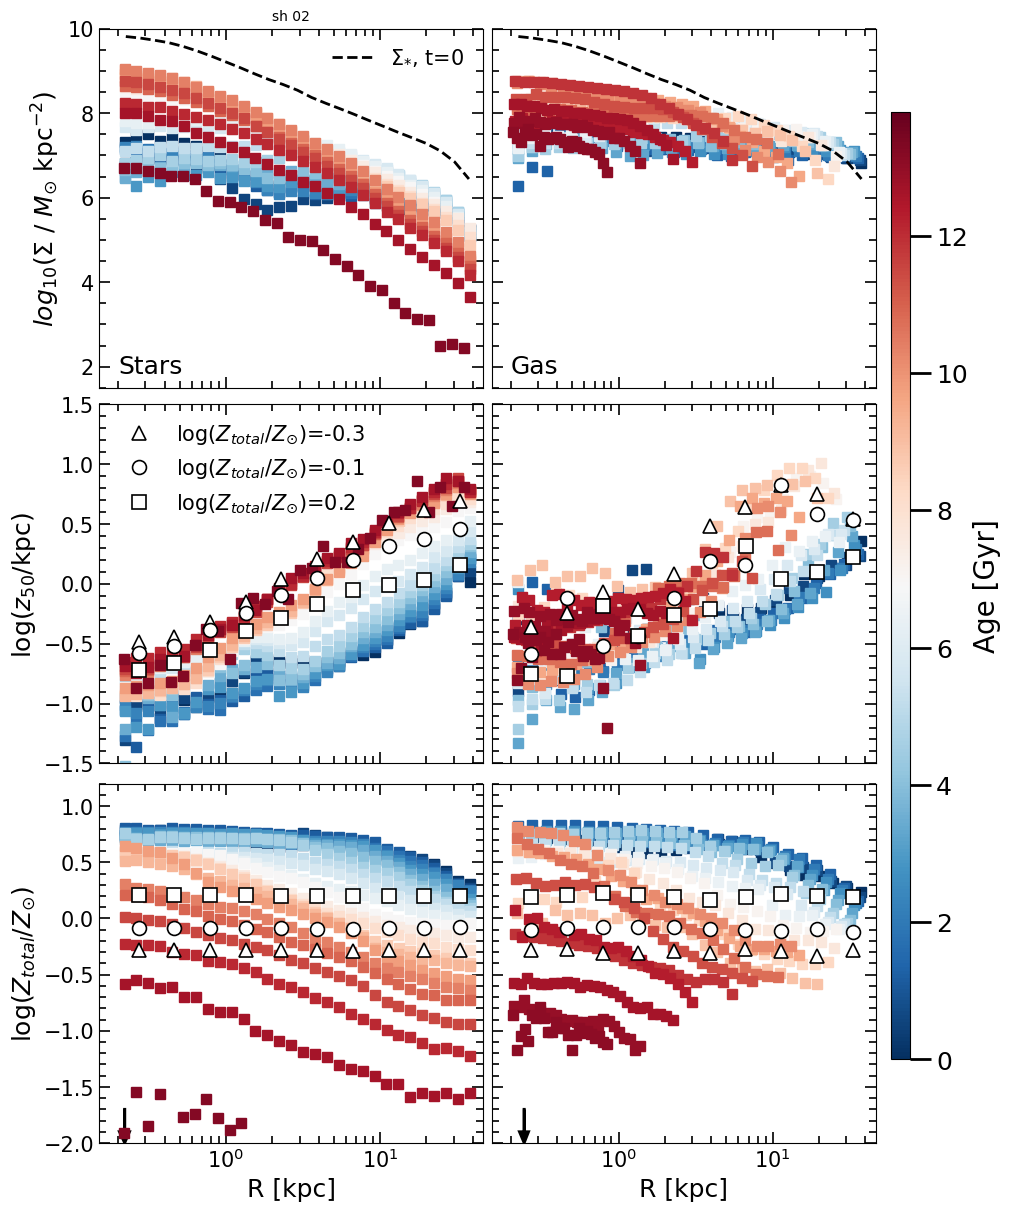

subhalo_127000000000003


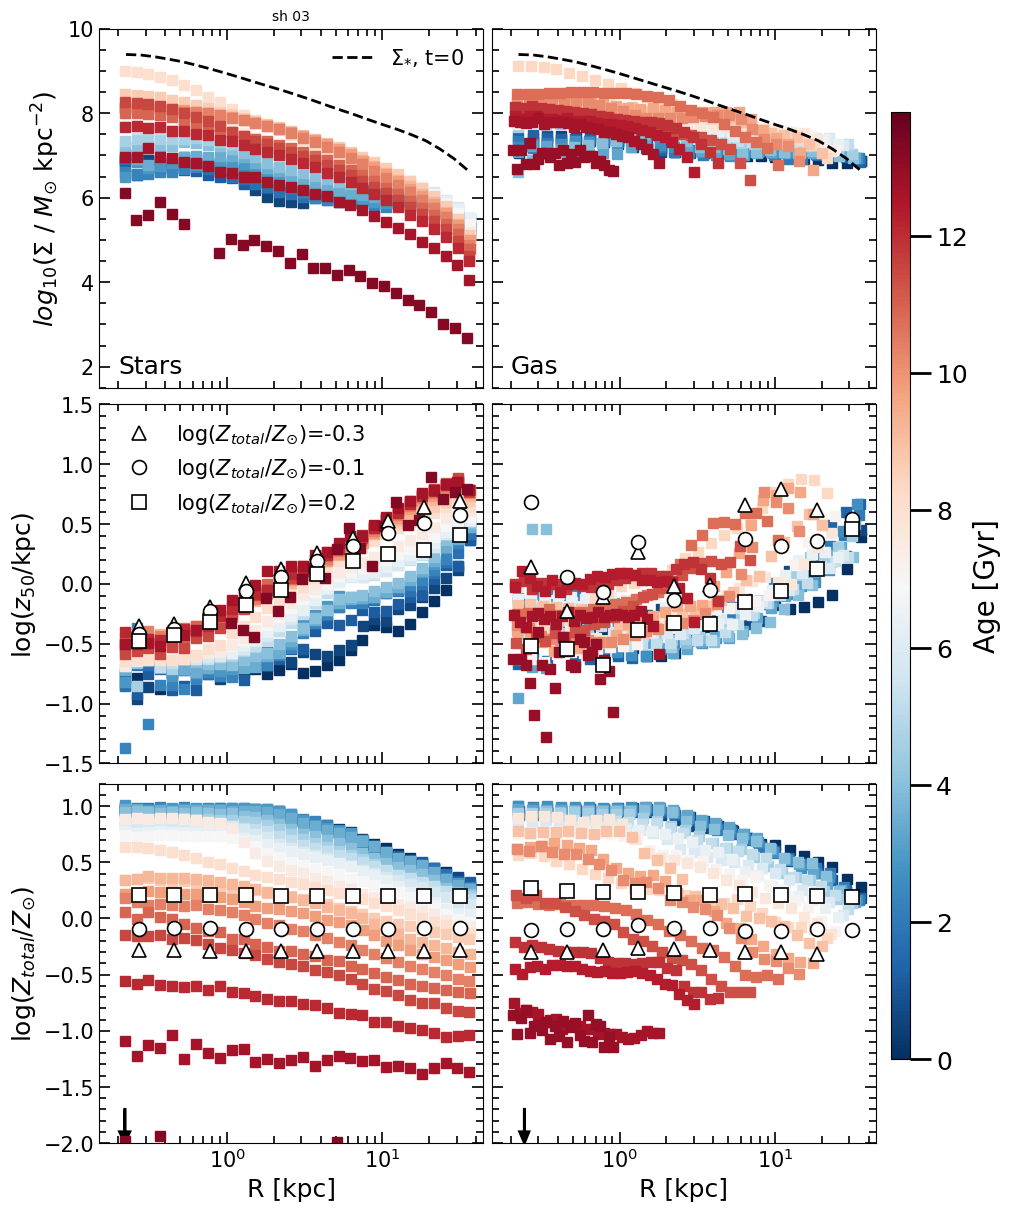

subhalo_127000000000004


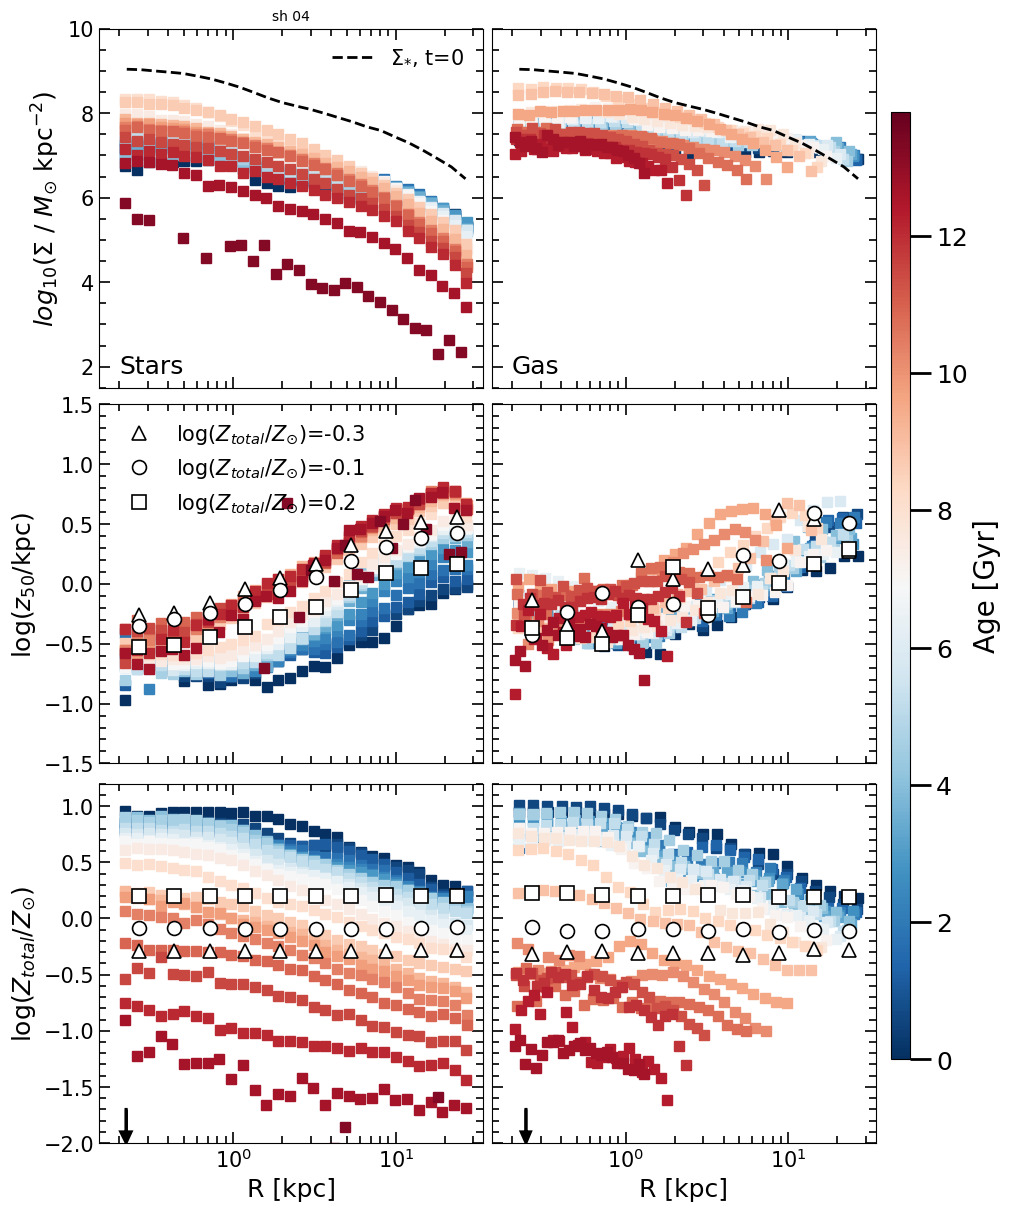

subhalo_127000000000006


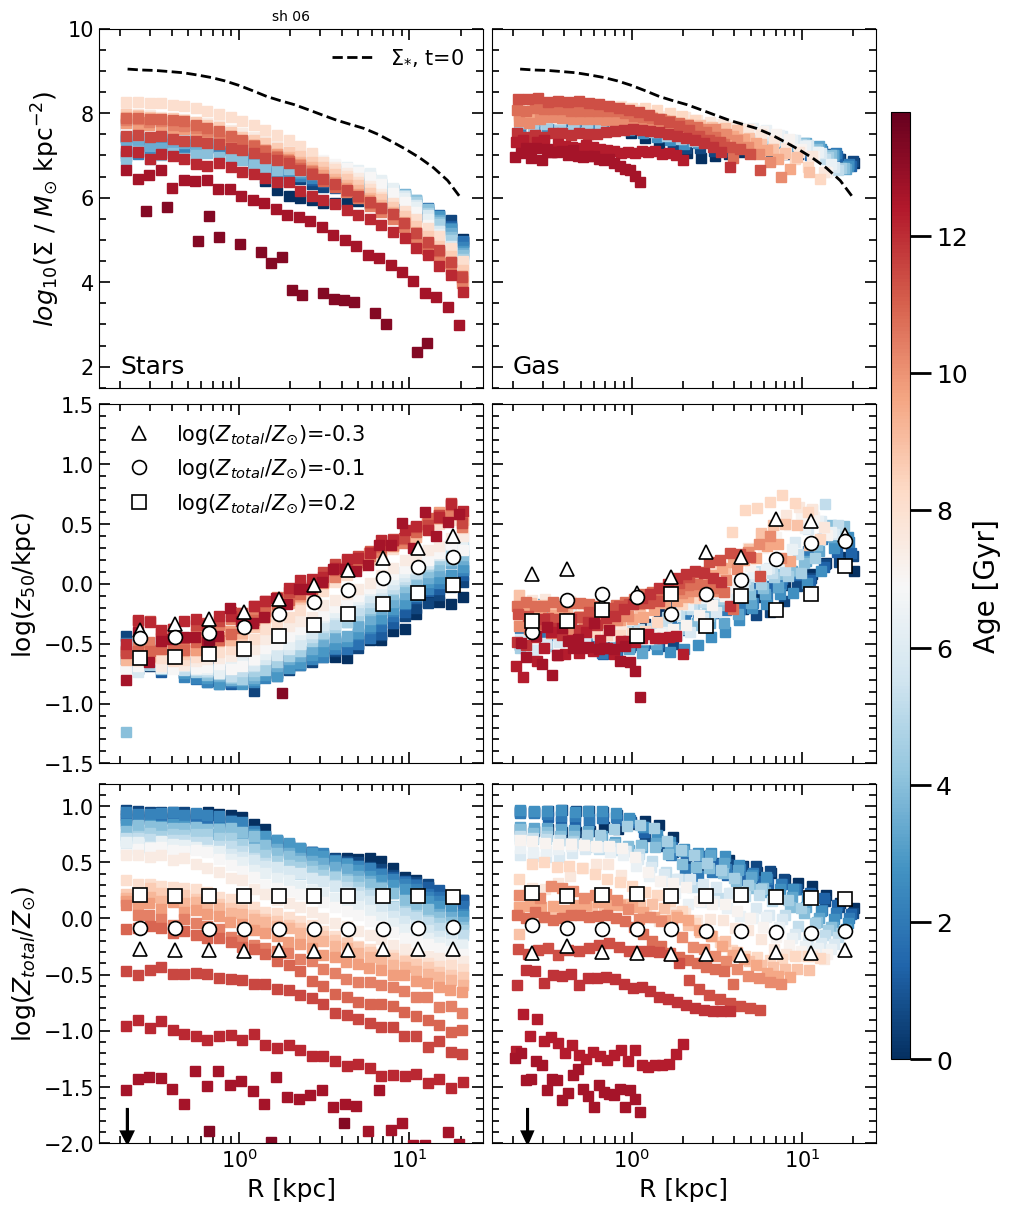

subhalo_127000000000007


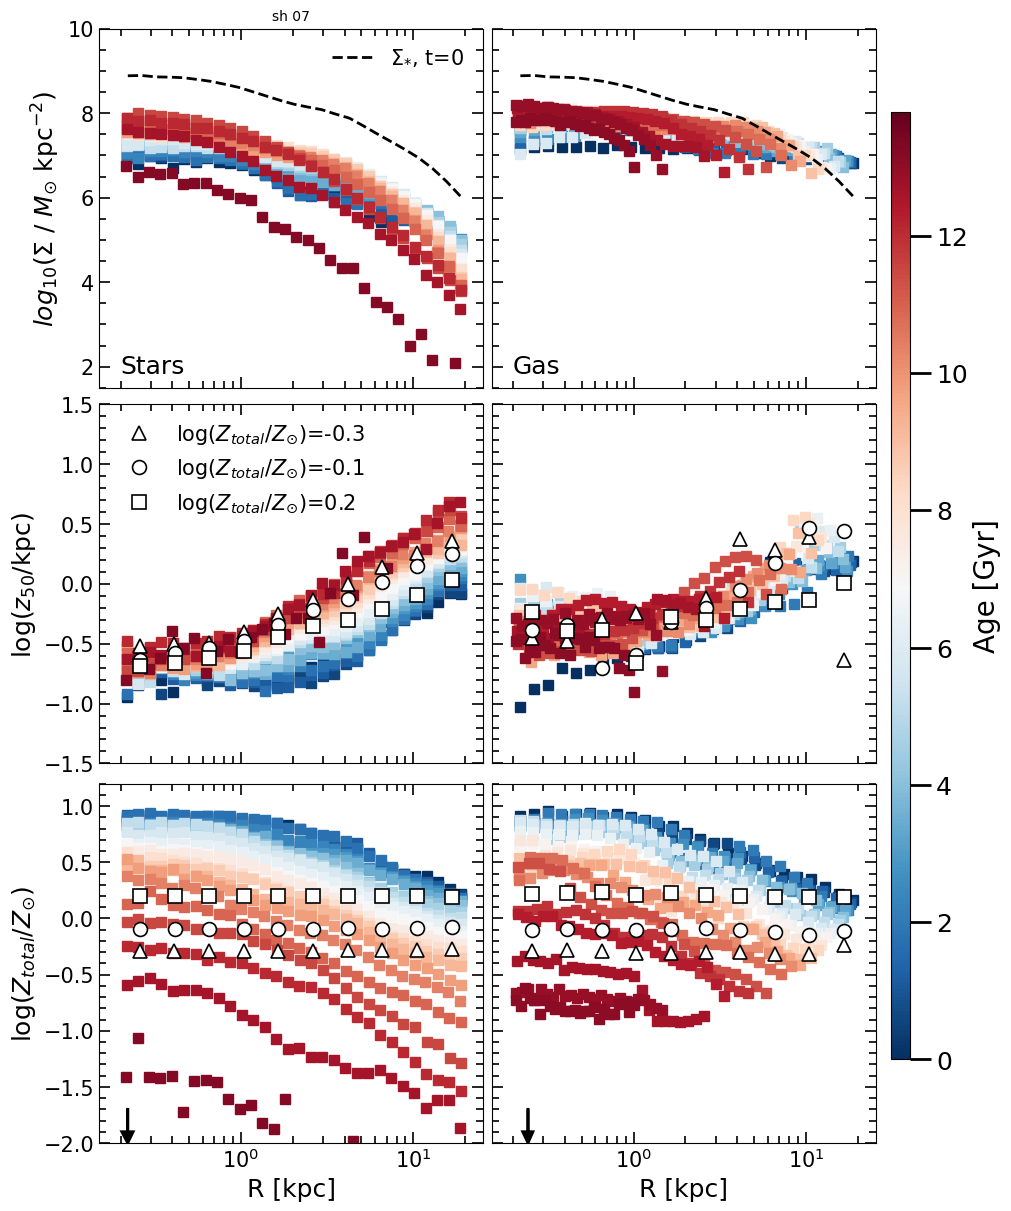

subhalo_127000000000009


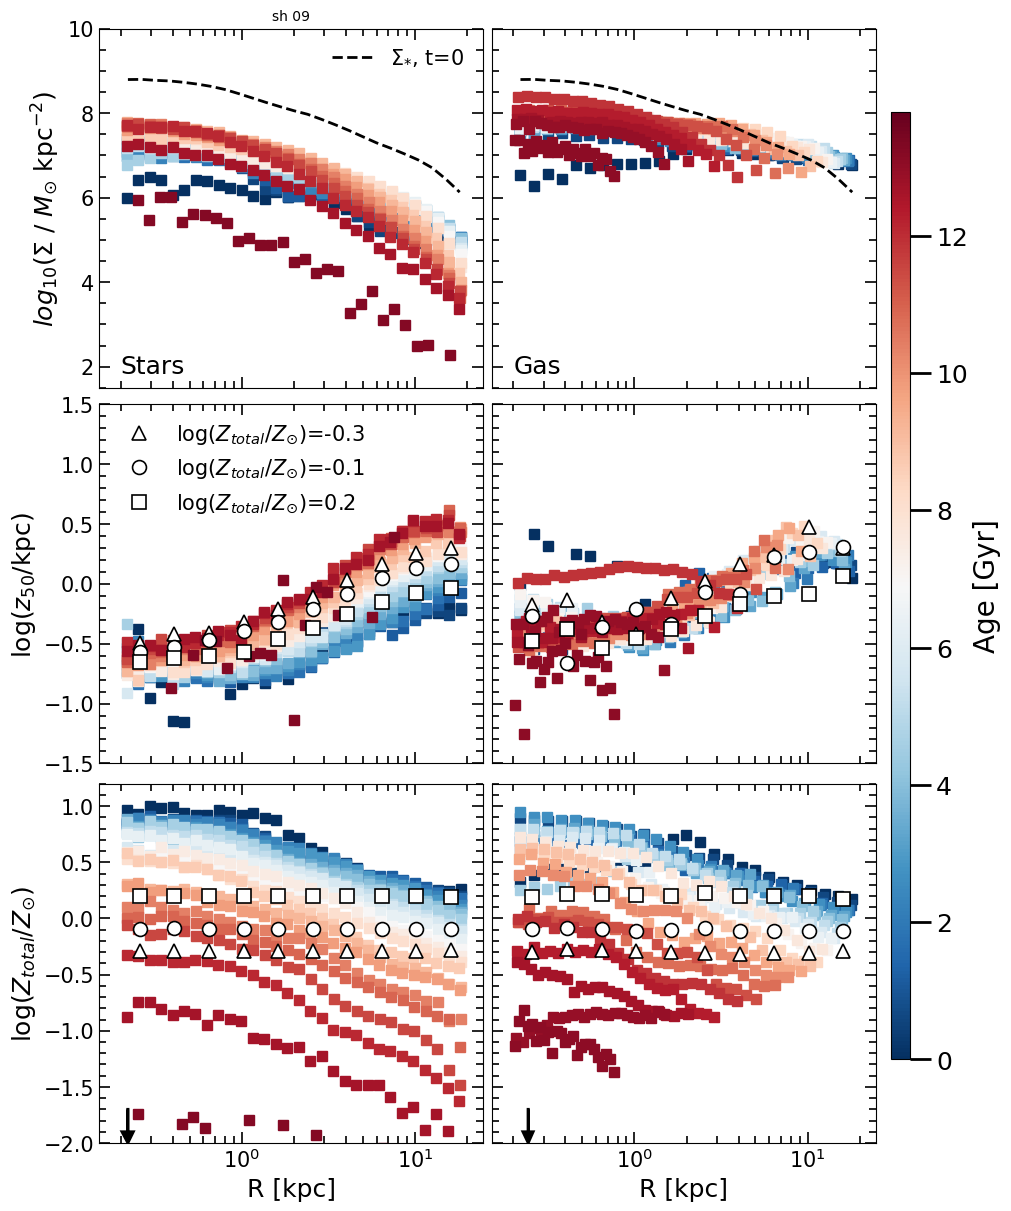

subhalo_127000000000012


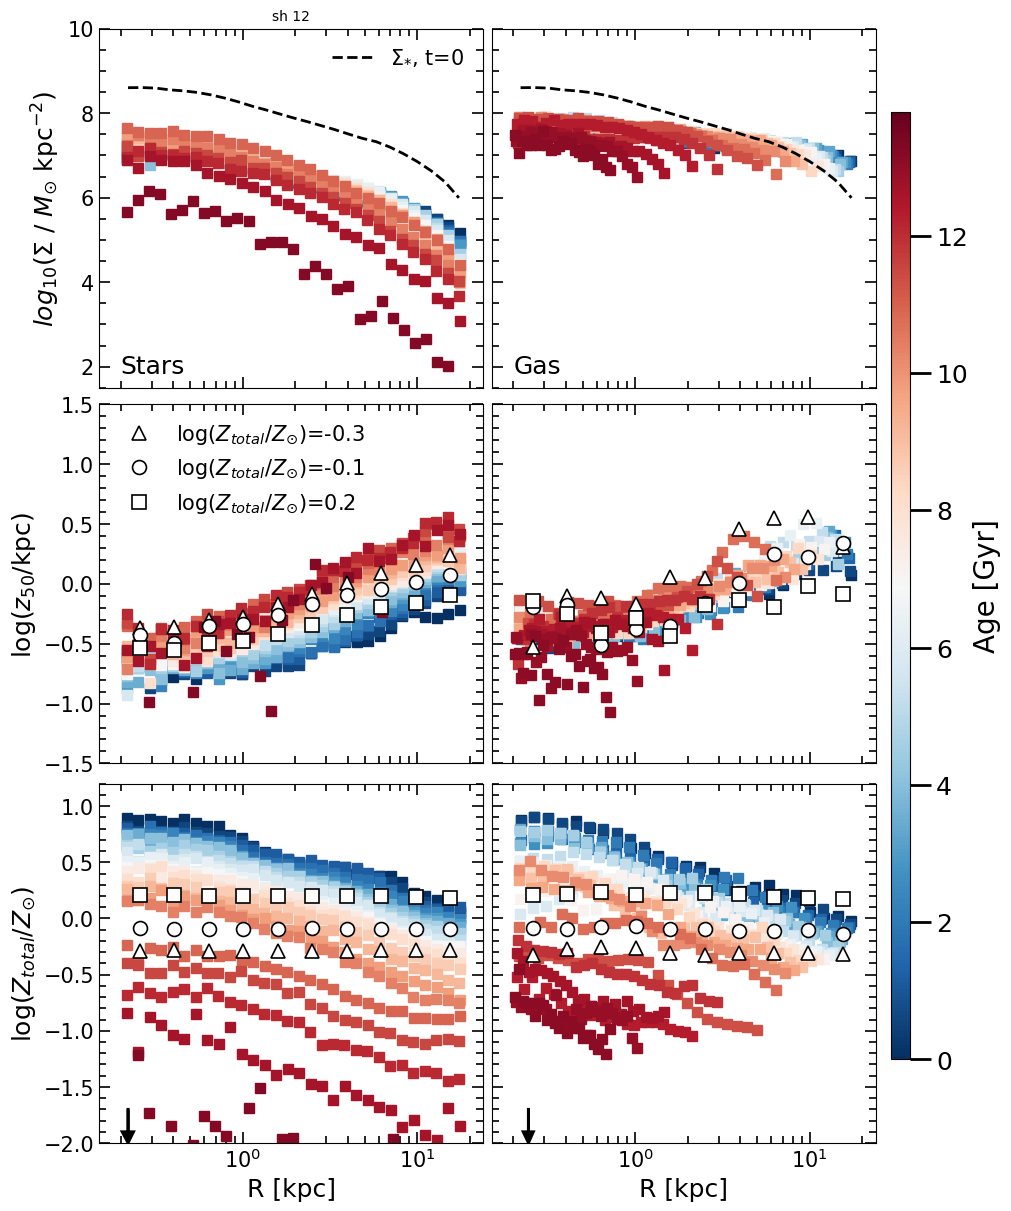

subhalo_127000000000011


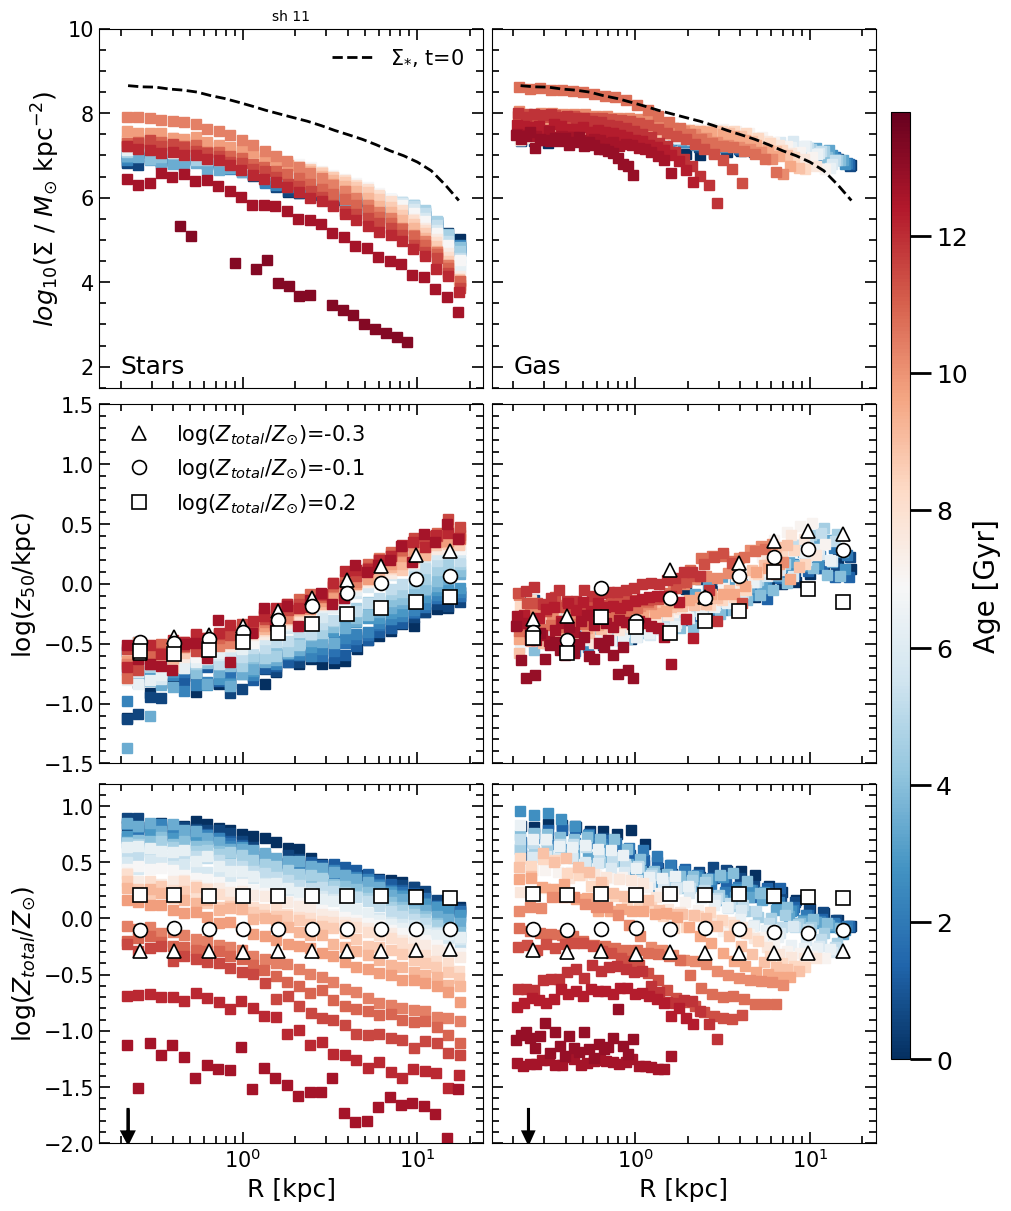

subhalo_127000000000014


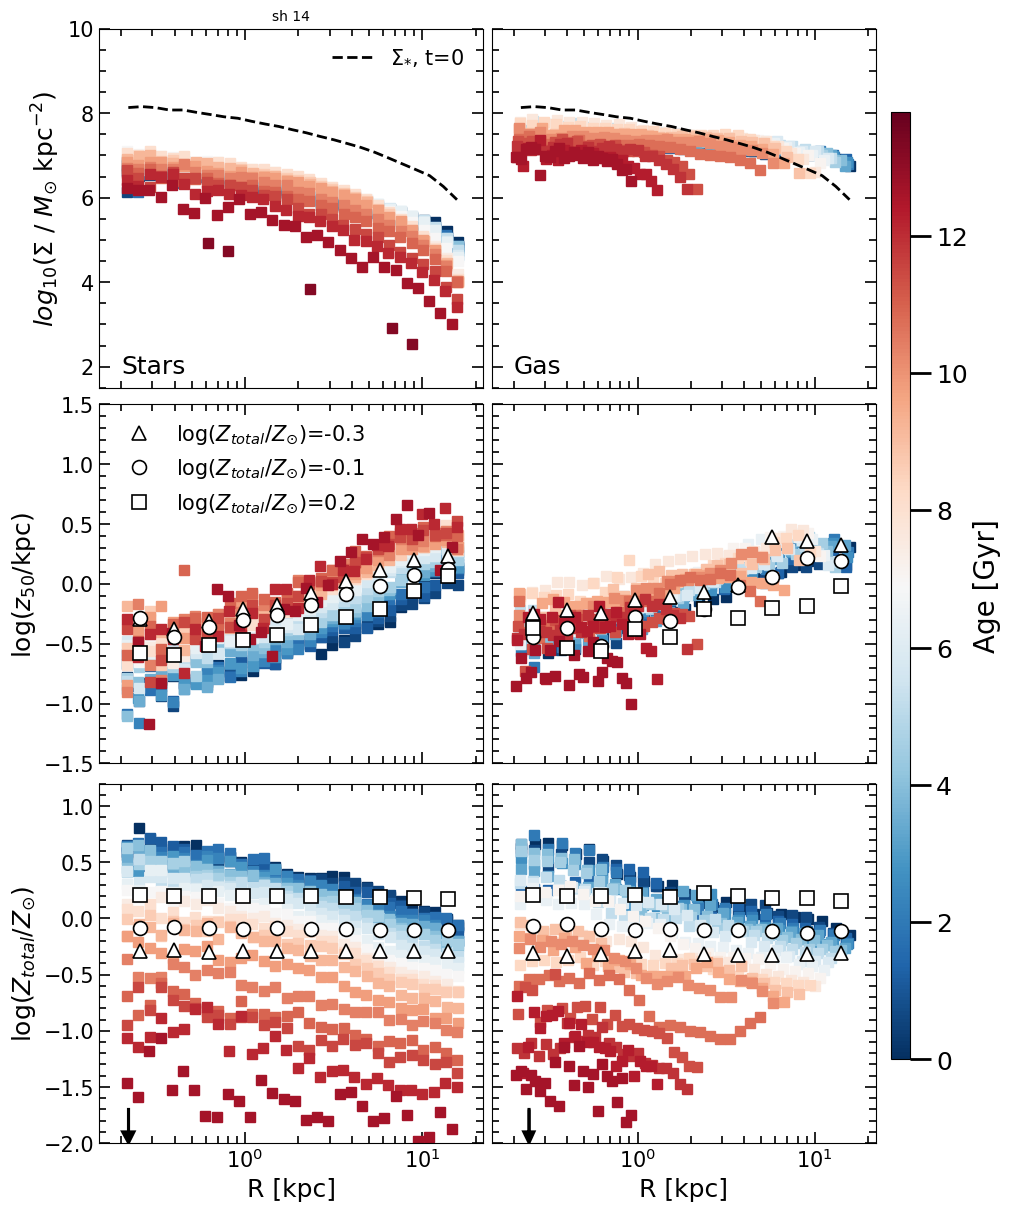

subhalo_127000000000020


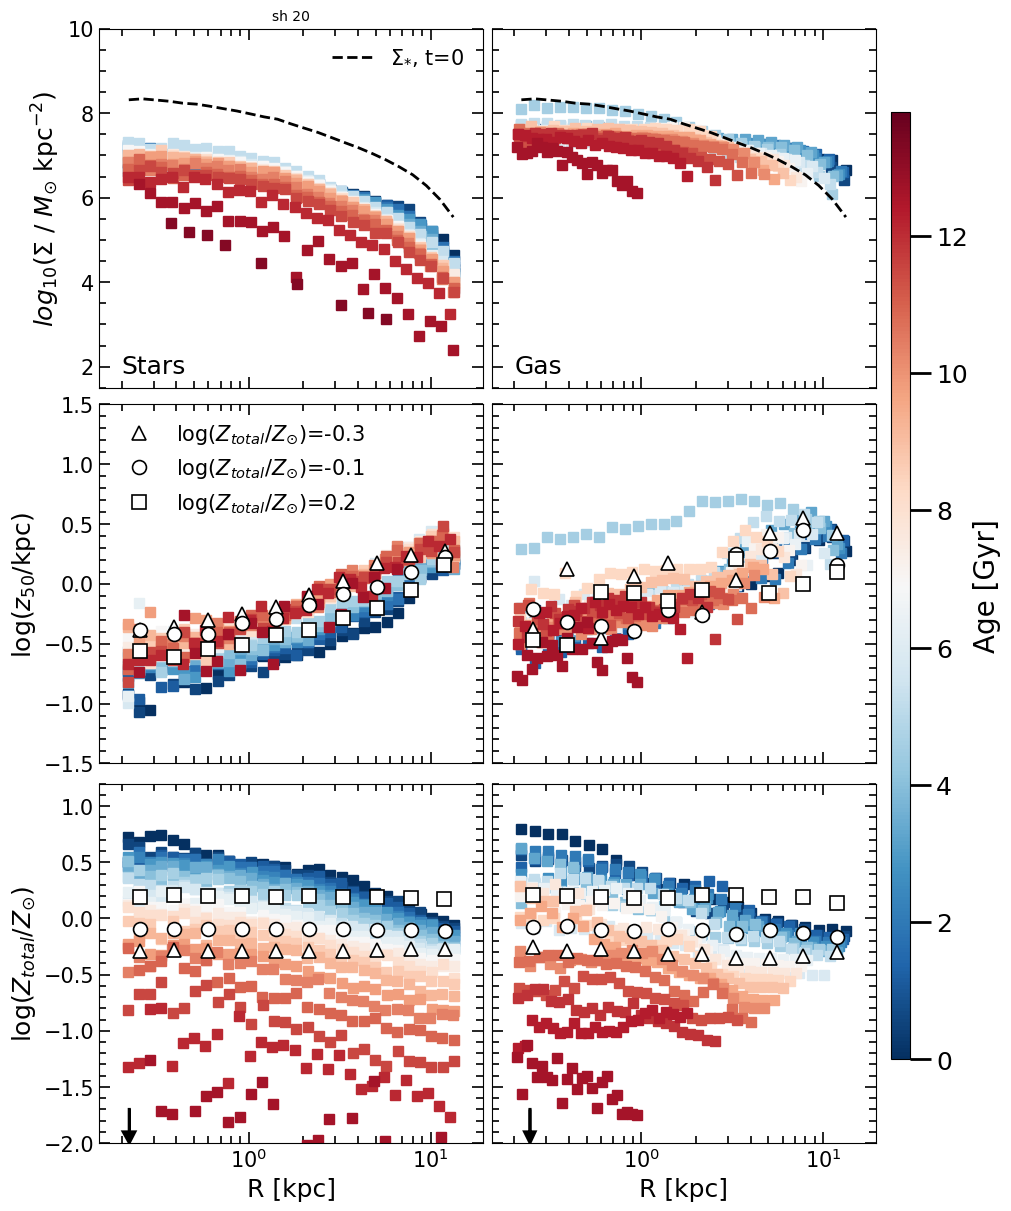

subhalo_127000000000021


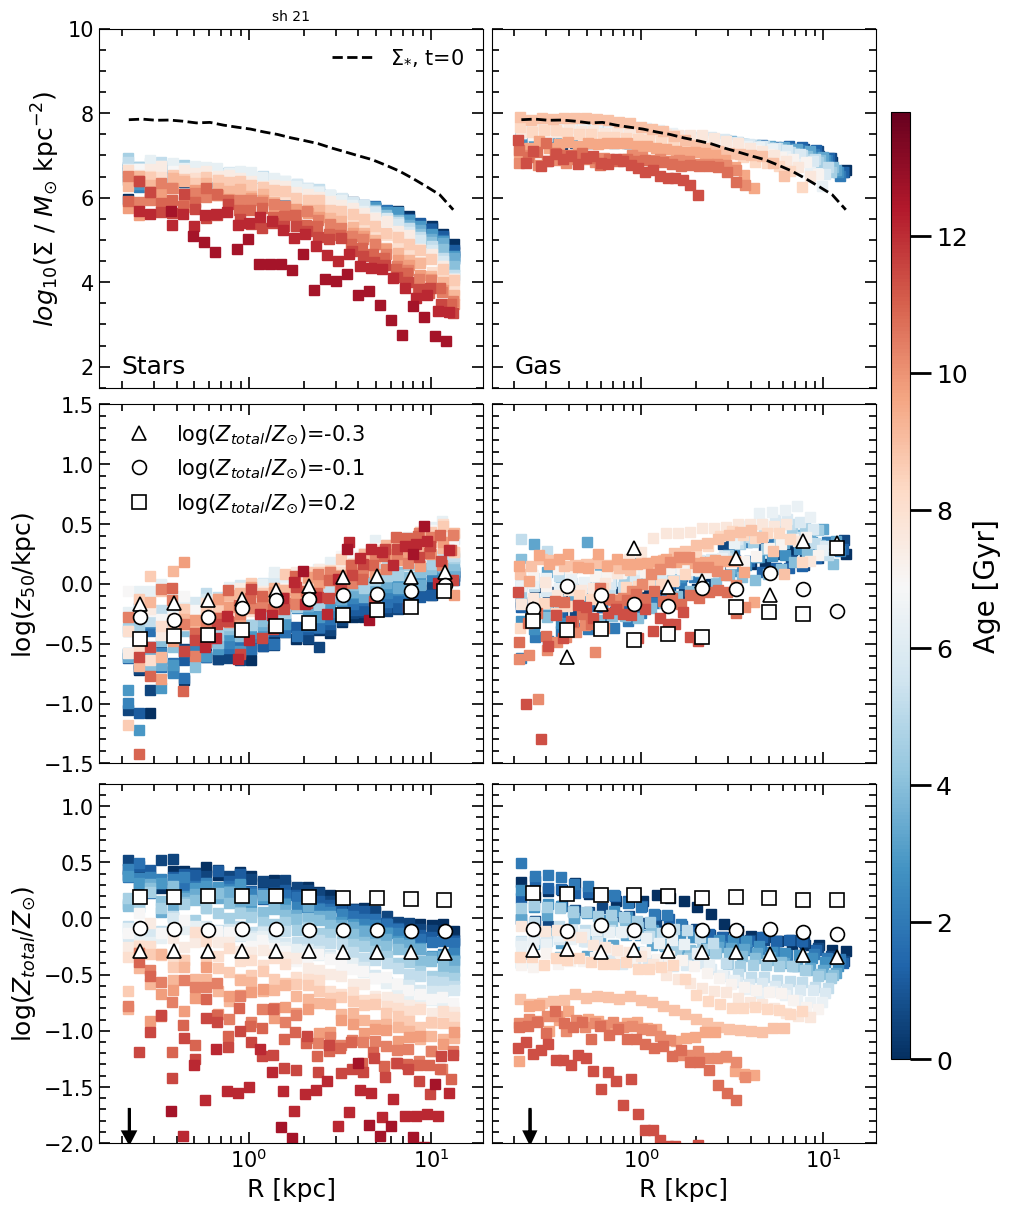

subhalo_127000000000023


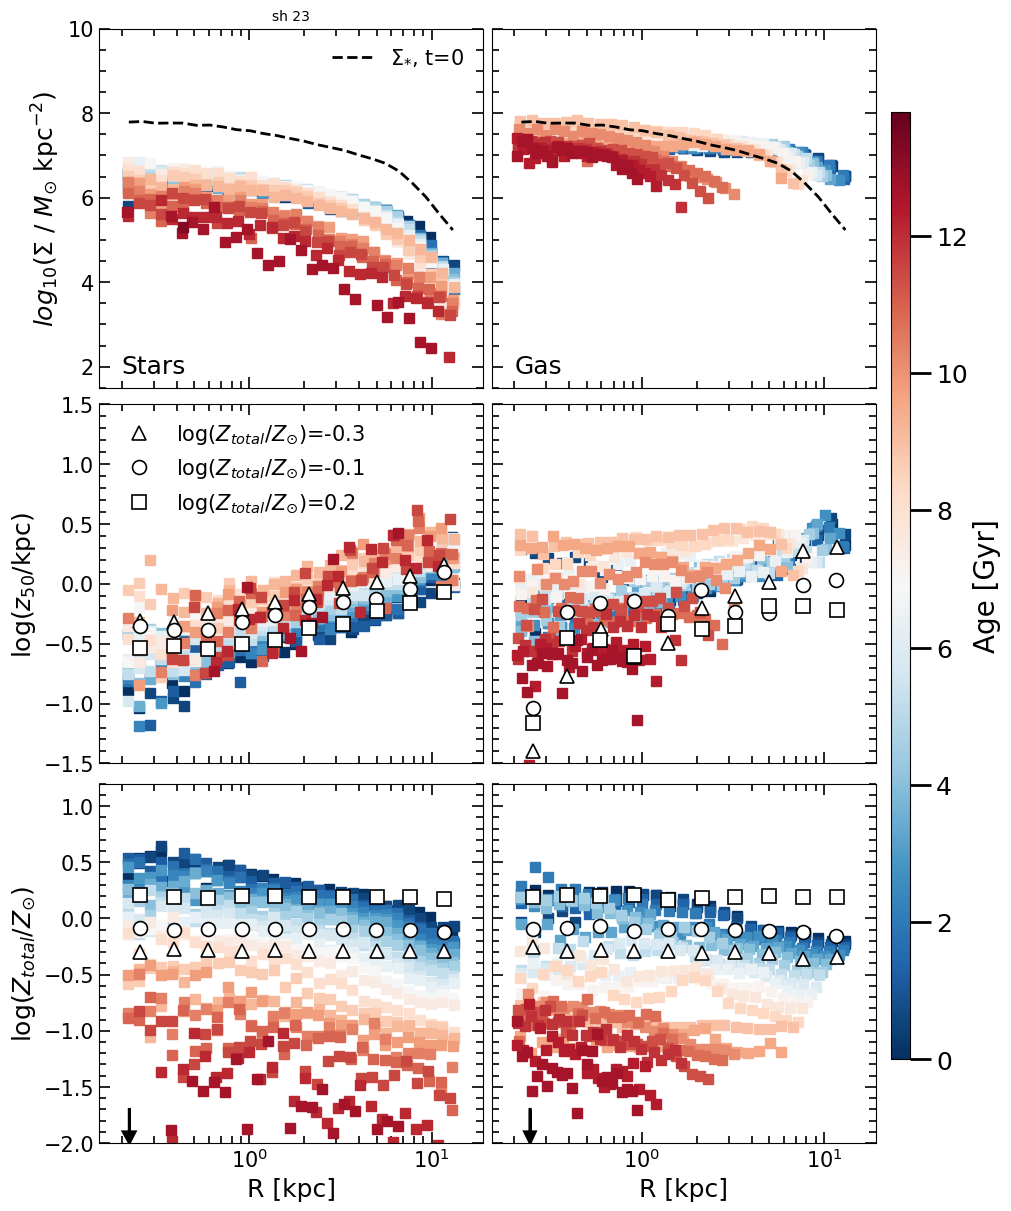

subhalo_127000000000028


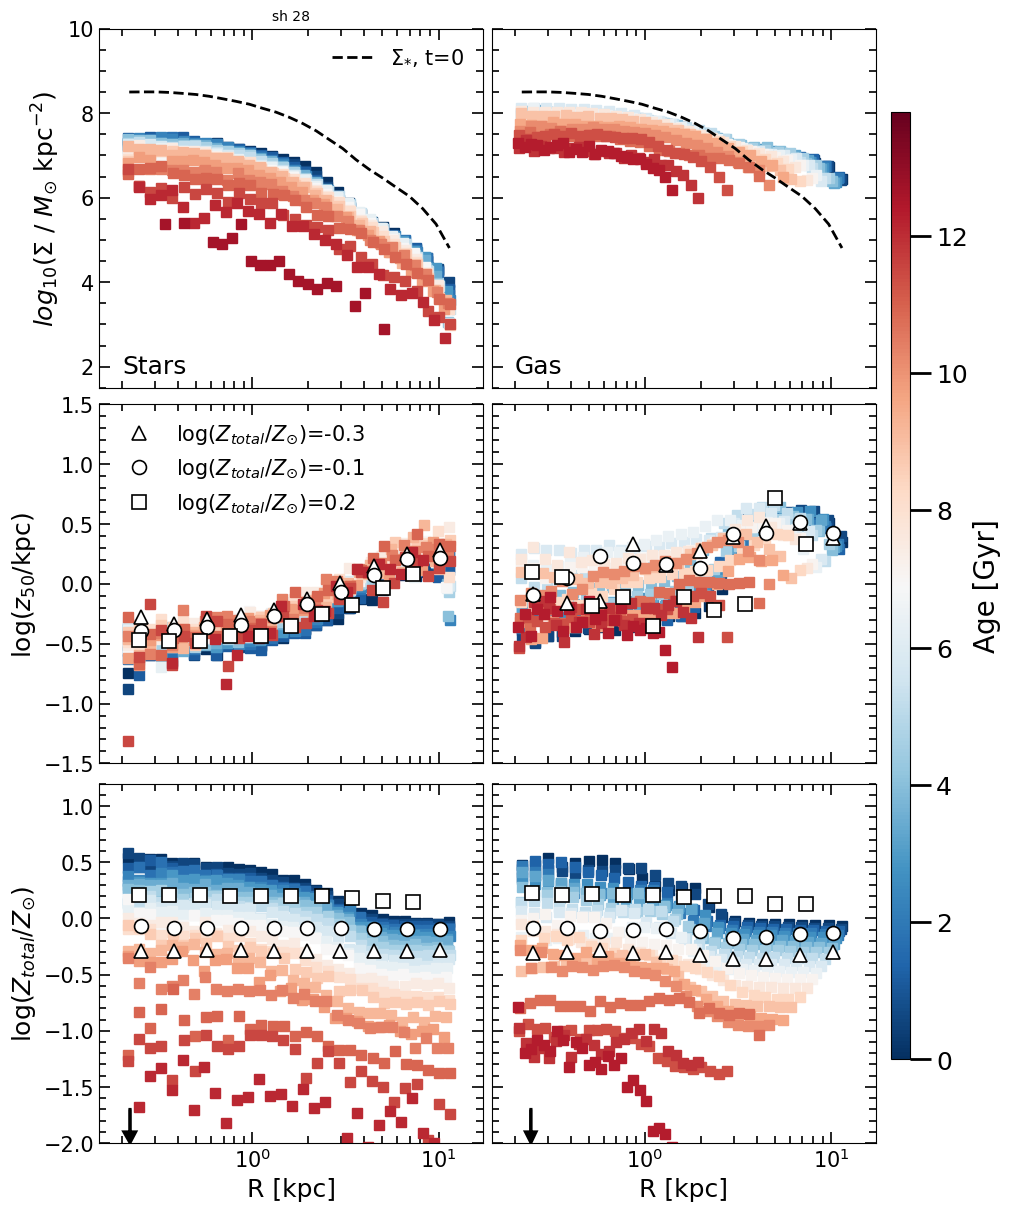

subhalo_127000000000031


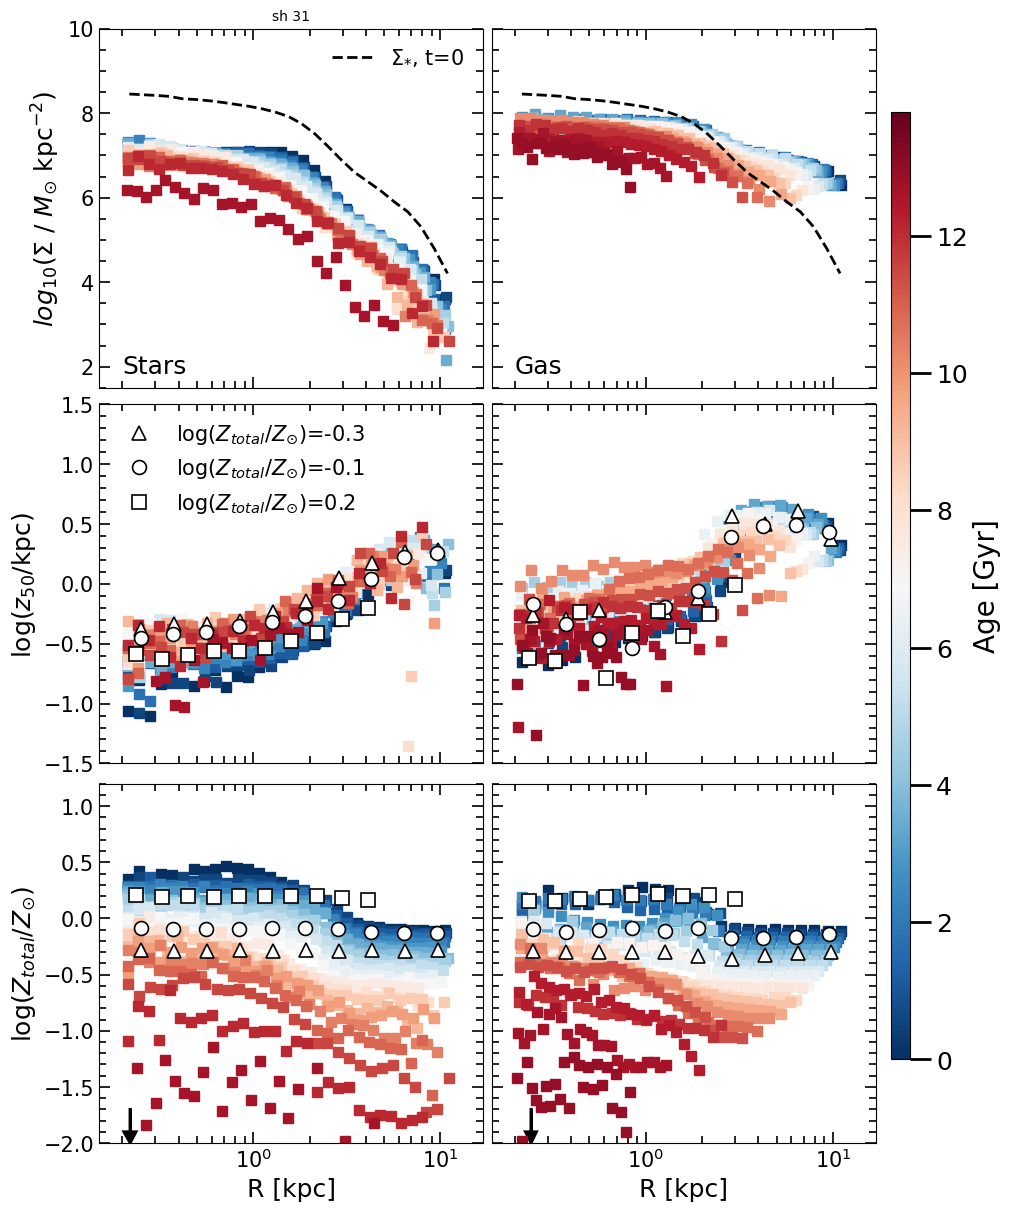

In [40]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import matplotlib as mpl
import density
import make_profiles as mprof
import z50

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

data = np.loadtxt('../_data/time.dat')
s = data[:,0]
T = data[:,3]

ages_gas = T.max() - T

valores = (-0.3,-0.1,0.2)
simbol = ('^','o','s')

for j in range(14):
    
    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')
    
    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux

    #densidad sup del gas -------------------------------------------------------------------
    SDP_ = np.loadtxt('../_data/gas_surfden/gas_surfden_log_prof_sh_'+str('%d'%ID[j])+'.dat')
    med_gas = SDP_[:,0]
    SDP_gas = SDP_[:,1]
    snap_gas = SDP_[:,2]
    #------------------------------------------------------------------------------------------
    #met gas ----------------------------------------------------------------------------------
    mett = np.loadtxt('../_data/gas_metallicity/gas_totalmet_log_prof_sh_'+str('%d'%ID[j])+'.dat')
    med_met_gas  = mett[:,0]
    Ztot_gas = mett[:,1]
    snap_met_gas =mett[:,2]
    #---------------------------------------------------------------------------------------------
    # z50_gas ------------------------------------------------------------------------------------
    z50p = np.loadtxt('../_data/gas_z50/gas_z50_log_prof_sh_'+str('%d'%ID[j])+'.dat')
    med_z50_gas = z50p[:,0]
    z50_gas = z50p[:,1]
    snap_z50_gas=z50p[:,2]
    #----------------------------------------------------------------------------------------------
    
    print ('subhalo_'+str('%d'%ID[j]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]
    
    sft  = snap['/Str/FormationTime'][()]
    met  = snap['/Str/Metallicity'][()]
    tmet = snap['/Str/Total_Metallicity'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    Ztot = tmet[amask]/0.0127

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h
    
    rgal = 0.15*Rvir*aexp/h
    
    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn  = e1x*xstr + e1y*ystr + e1z*zstr
    yn  = e2x*xstr + e2y*ystr + e2z*zstr
    zn  = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    rn = np.sqrt(xn**2 + yn**2 + zn**2 )
    
    limit2, = np.where(rn < rgal )
    
    w0, = np.where(Ztot[limit2]>0)
    
    edad  = age[limit2][w0]
    x_str = xn[limit2][w0]
    y_str = yn[limit2][w0]
    z_str = zn[limit2][w0]
    Z_tot = Ztot[limit2][w0]
    m_str = mstr[limit2][w0]
    
    Rstr = np.sqrt(x_str**2+y_str**2)
    
    bines=25
    sigma_tot, med_tot = density.surf_density_log(Rstr,m_str,bines)
    
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,12),sharex=True, sharey='row', 
                       gridspec_kw={'hspace': 0, 'wspace': 0}, constrained_layout=True)
    # fig.subplots_adjust(bottom=0.15, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)

    nb = 24

    delta = (13.8-0.)/nb
    rango = np.arange(0,13.8,delta)

    rango_gas = np.arange(0,len(s),4)
    
    color_range = np.linspace(0,13.8,nb)
    norm = mpl.colors.Normalize(vmin = color_range.min(),vmax= color_range.max())
    cmap = mpl.cm.ScalarMappable(norm = norm, cmap = 'RdBu_r')

    # cbar = fig.colorbar(cmap, ax=ax, orientation='horizontal', ticks=np.arange(0, 15, 2), 
    #                 shrink=0.85, pad=0.05, aspect=40, location='top')
    cbar = fig.colorbar(cmap, ax=ax.ravel().tolist(), orientation='vertical', ticks=np.arange(0, 15, 2), 
                    shrink=0.85, pad=0.02, aspect=50, location='right')
    cbar.set_label('Age [Gyr]',fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.tick_params(length=15, width=2, which='major')
    
    for i in rango:
        
        agelim, = np.where((edad>i) & (edad<i+delta))
        
        if len(agelim)==0 or len(agelim)==1:
            continue
            
        R = Rstr[agelim]
        z = z_str[agelim]
        m = m_str[agelim]
        Ztotal = Z_tot[agelim]
    
        nbin = 30
        sigma, med = density.surf_density_log(R,m,nbin)
        med_Zt, Z_t, p25_aux, p75_aux = mprof.profile_log(R,np.log10(Ztotal),nbin)
        med_z50, z_50, n_aux, p25_aux, p75_aux = z50.HMSH_log(R,z,m,nbin)
        
        ax[0,0].plot(med, np.log10(sigma), 's',ms=7.5, color = cmap.to_rgba(i))
        ax[1,0].plot(med_z50, np.log10(z_50),'s',ms=7.5,color = cmap.to_rgba(i))
        ax[2,0].plot(med_Zt, Z_t, 's',ms=7.5,color = cmap.to_rgba(i))

    for i in rango_gas:
        select_SDP, = np.where(snap_gas == s[i])
        select_met, = np.where(snap_met_gas == s[i])
        select_z50, = np.where(snap_z50_gas == s[i])
        
        ax[0,1].plot(med_gas[select_SDP],np.log10(SDP_gas[select_SDP]), 's',ms=7.5,
                     color = cmap.to_rgba(ages_gas[i]))
        ax[2,1].plot(med_met_gas[select_met],Ztot_gas[select_met],'s',ms=7.5,color = cmap.to_rgba(ages_gas[i]))

        ax[1,1].plot(med_z50_gas[select_z50],np.log10(z50_gas[select_z50]), 's',ms=7.5,
                     color = cmap.to_rgba(ages_gas[i]))

    for k in range(3):
        rango, = np.where((np.log10(Z_tot)>valores[k] - 0.1) & (np.log10(Z_tot)< valores[k] + 0.1))
    
        med_R, Z_R, p25_met, p75_met = mprof.profile_log(Rstr[rango],np.log10(Z_tot[rango]),10)
        med_zR, z50_R, nodos, p25_z50, p75_z50 = z50.HMSH_log(Rstr[rango],z_str[rango],m_str[rango],10)
        
        ax[2,0].plot(med_R,Z_R, simbol[k], ms=10, color='w',mec='k',mew=1.2,
                 label=r'log($Z_{total}/Z_{\odot}$)='+str('%s'%valores[k]))
        ax[1,0].plot(med_zR,np.log10(z50_R),simbol[k], ms=10, color='w',mec='k', mew=1.2, 
                     label=r'log($Z_{total}/Z_{\odot}$)='+str('%s'%valores[k]))

        points = np.loadtxt('../_data/gas_Ztot_points/gas_Ztot_points_'+str('%s'%valores[k])+'_sh_'+str('%d'%ID[j])+'.dat')
        med_points_gas = points[:,0]
        met_points_gas = points[:,4]
        ax[2,1].plot(med_points_gas,np.log10(met_points_gas),simbol[k], ms=10, color='w',mec='k',mew=1.2, 
                label=r'log($Z_{total}/Z_{\odot}$)='+str('%s'%valores[k]))

        
        points = np.loadtxt('../_data/gas_Ztot_points/gas_Ztot_points_'+str('%s'%valores[k])+'_sh_'+str('%d'%ID[j])+'.dat')
        med_P = points[:,0]
        z50_P = points[:,1]
        
        ax[1,1].plot(med_P,np.log10(z50_P),simbol[k], ms=10, color='w',mec='k',mew=1.2,
                label=r'log($Z_{total}/Z_{\odot}$)='+str('%s'%valores[k]),zorder=100)


    for a in ax.flatten():
        a.minorticks_on()
        a.tick_params( labelsize=15)
        a.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
        a.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
            
    ax[0,0].plot(med_tot,np.log10(sigma_tot), '--k',lw=2, label=r'$\Sigma_{*}$, t=0')
    ax[0,0].set_xscale('log')
    ax[0,0].set_ylim(1.5,10)
    ax[0,0].set_xlim(0.15,rgal+5)
    ax[0,0].set_title('sh '+Id, fontsize=10)
    ax[0,0].text(0.2, 2, 'Stars', fontsize=18, color='k', ha='left', va='center')
    ax[0,0].set_ylabel(r'$log_{10}$($\Sigma$ / $M_{\odot}$ kpc$^{-2}$)',fontsize=18)
    # ax[0,0].set_xlabel('R [kpc]',fontsize=15)
    ax[0,0].legend(fontsize=15,frameon=False,loc=1)

    ax[1,0].set_xscale('log')
    ax[1,0].set_ylim(-1.5,1.5)
    ax[1,0].set_ylabel('log($z_{50}$/kpc)',fontsize=18)
    ax[1,0].legend(fontsize=15,frameon=False, loc=2)
    # ax[1,0].arrow(0.244,-1.1,0,-0.4,
    #     length_includes_head=True, head_width=1./60, head_length=0.1,
    #     lw=2,color='k')

    ax[2,0].set_xscale('log')
    ax[2,0].set_ylim(-2,1.2)
    ax[2,0].set_ylabel(r'log($Z_{total}/Z_{\odot}$)',fontsize=18)
    ax[2,0].set_xlabel('R [kpc]',fontsize=18)
    ax[2,0].arrow(0.22,-1.7,0,-0.3,
        length_includes_head=True, head_width=1./30, head_length=0.1,
        lw=2,color='k') 

    ax[0,1].plot(med_tot,np.log10(sigma_tot), '--k',lw=2, label=r'$\Sigma_{*}$, t=0')
    ax[0,1].set_xscale('log')
    ax[0,1].text(0.2, 2, 'Gas', fontsize=18, color='k', ha='left', va='center')
    
    
    ax[1,1].set_xscale('log')
    # ax[1,1].arrow(0.244,-1.2,0,-0.3,
    #     length_includes_head=True, head_width=1./50, head_length=0.1,
    #     lw=2,color='k') 

    ax[2,1].set_xscale('log')
    ax[2,1].set_xlabel('R [kpc]',fontsize=18)
    ax[2,1].arrow(0.244,-1.7,0,-0.3,
        length_includes_head=True, head_width=1./30, head_length=0.1,
        lw=2,color='k')


    plt.show()
    fig.savefig('../_imagenes/6in1_profiles/6in1_prof_'+str('%d'%ID[j])+'.png',dpi=100)#, xxbox_inches='tight')

Den sup gas


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

shID = np.loadtxt('../_data/my_halos.dat')[:,0]
R200 = np.loadtxt('../_data/my_halos.dat')[:,2]
rgal=0.15*R200
data = np.loadtxt('../_data/time.dat')
s = data[:,0]
T = data[:,3]

ages = T.max() - T
# mask,  = np.where((ages >= 4) & (ages <=10))

for j in range(14):
    
    Id = ''
    for aux in list(str('%d'%shID[j]))[-2:]:
        Id += aux
        
    perfil = np.loadtxt('../_data/densup_profile/perfil_densup_sh_'+str('%d'%shID[j])+'.dat')
    med_tot = perfil[:,0]
    sigma_tot = perfil[:,1]
        
    SDP_ = np.loadtxt('../_data/gas_surfden/gas_surfden_log_prof_sh_'+str('%d'%shID[j])+'.dat')
    med = SDP_[:,0]
    SDP = SDP_[:,1]
    snap = SDP_[:,2]

    print(shID[j])
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
    fig.subplots_adjust(bottom=0.15, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)

    rango = np.arange(0,len(s),3)

    #Esto es para la barra de colores
    color_range = np.linspace(0,13.8,len(rango))
    norm = mpl.colors.Normalize(vmin = color_range.min(),vmax= color_range.max())
    cmap = mpl.cm.ScalarMappable(norm = norm, cmap = 'RdBu_r')

    for i in rango:
        select, = np.where(snap == s[i])
        ax.plot(med[select],np.log10(SDP[select]), 's',ms=7.5,color = cmap.to_rgba(ages[i]))

    cbar = fig.colorbar(cmap,ticks=[0,2,4,6,8,10,12,14]) #pad=0.01)
    cbar.set_label('Age [Gyr]',fontsize=15)
    cbar.ax.tick_params( labelsize=15)
    cbar.ax.tick_params(length=8, width=1.2, which='major')
    
    ax.plot(med_tot,np.log10(sigma_tot), '--k',lw=2, label=r'$\Sigma_{*}$, t=0')
    ax.set_xscale('log')
    ax.set_ylim(1.5,10)
    ax.set_xlim(0.15,rgal[j]+5)
    ax.minorticks_on()
    ax.tick_params( labelsize=15)
    ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
    ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
    ax.set_ylabel(r'$log_{10}$($\Sigma$ / $M_{\odot}$ $kpc^{-2}$)',fontsize=15)
    ax.set_xlabel('R [kpc]',fontsize=15)
    ax.set_title('GAS - sh '+Id, fontsize=15)
    ax.legend(fontsize=13,frameon=False,loc=1)

    plt.show()

    # fig.savefig('../_imagenes/surf_density_gas_profile/sd_gas_log_sh_'+str('%d'%shID[j])+'.png',dpi=100, xxbox_inches='tight')

metalicidad y z50 estrellas

In [ ]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import matplotlib as mpl
import metallicity_profile as metp
import z50

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

valores = (-0.3,-0.1,0.2)
simbol = ('^','o','s')

for j in range(14):

    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')

    print('subhalo_'+str('%d'%ID[j]))
    
    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]

    sft  = snap['/Str/FormationTime'][()]
    met  = snap['/Str/Metallicity'][()]
    tmet = snap['/Str/Total_Metallicity'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)
    
    Ztot = tmet[amask]/0.0127

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h

    rgal = 0.15*Rvir*aexp/h

    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn  = e1x*xstr + e1y*ystr + e1z*zstr
    yn  = e2x*xstr + e2y*ystr + e2z*zstr
    zn  = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    rn = np.sqrt(xn**2 + yn**2 + zn**2 )

    limit2, = np.where(rn < rgal)
    w0, = np.where(Ztot[limit2]>0)
    
    edad  = age[limit2][w0]
    x_str = xn[limit2][w0]
    y_str = yn[limit2][w0]
    z_str = zn[limit2][w0]
    Z_tot = Ztot[limit2][w0]
    m_str = mstr[limit2][w0]
    
    Rstr = np.sqrt(x_str**2 + y_str**2)
    
    fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
    fig1.subplots_adjust(bottom=0.15, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)

    fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
    fig2.subplots_adjust(bottom=0.15, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)
    
    nb = 25

    delta = (13.8-0.)/nb
    rango = np.arange(0,13.8,delta)

    #Esto es para la barra de colores
    color_range = np.linspace(0,13.8,nb)
    norm = mpl.colors.Normalize(vmin = color_range.min(),vmax= color_range.max())
    cmap = mpl.cm.ScalarMappable(norm = norm, cmap = 'RdBu_r')
    
    for i in rango:

        agelim, = np.where((edad>i) & (edad<i+delta))

        R = np.sqrt(x_str[agelim]**2 + y_str[agelim]**2)
        z = z_str[agelim]
        m = m_str[agelim]
        Ztotal = Z_tot[agelim]
    
        nbin = 50
        
        if (len(agelim)==0 or len(agelim)==1):
            continue

        med_Zt, Z_t, p25_aux, p75_aux = metp.met_log(R,np.log10(Ztotal),nbin)
        med_z50, z_50, n_aux, p25_aux, p75_aux = z50.HMSH_log(R,z,m,nbin)

        ax2.plot(med_z50,np.log10(z_50),'s',ms=7.5,color = cmap.to_rgba(i))
        ax1.plot(med_Zt,Z_t, 's',ms=7.5,color = cmap.to_rgba(i))

    
    for k in range(3):
        rango, = np.where((np.log10(Z_tot)>valores[k] - 0.1) & (np.log10(Z_tot)< valores[k] + 0.1))
    
        med_R, Z_R, p25_met, p75_met = metp.met_log(Rstr[rango],np.log10(Z_tot[rango]),10)
        med_zR, z50_R, nodos, p25_z50, p75_z50 = z50.HMSH_log(Rstr[rango],z_str[rango],m_str[rango],10)
        
        ax1.plot(med_R,Z_R, simbol[k], ms=10, color='w',mec='k',mew=1.2,
                 label=r'log($Z_{total}/Z_{\odot}$)='+str('%s'%valores[k]))
        ax2.plot(med_zR,np.log10(z50_R),simbol[k], ms=10, color='w',mec='k', mew=1.2, 
                     label=r'log($Z_{total}/Z_{\odot}$)='+str('%s'%valores[k]))
    
        
    cbar1 = fig1.colorbar(cmap,ticks=[0,2,4,6,8,10,12,14]) #pad=0.01)
    cbar1.set_label('Age [Gyr]',fontsize=15)
    cbar1.ax.tick_params( labelsize=15)
    cbar1.ax.tick_params(length=8, width=1.2, which='major')
    
    cbar2 = fig2.colorbar(cmap,ticks=[0,2,4,6,8,10,12,14]) #pad=0.01)
    cbar2.set_label('Age [Gyr]',fontsize=15)
    cbar2.ax.tick_params( labelsize=15)
    cbar2.ax.tick_params(length=8, width=1.2, which='major')
    
    
    ax1.set_xscale('log')
    ax1.set_ylim(-2,1.2)
    ax1.set_xlim(0.15,rgal+5)
    ax1.minorticks_on()
    ax1.tick_params( labelsize=15)
    ax1.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
    ax1.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
    ax1.set_ylabel(r'log($Z_{total}/Z_{\odot}$)',fontsize=15)
    ax1.set_xlabel('R [kpc]',fontsize=15)
    ax1.legend(fontsize=15,fancybox=True)
    ax1.set_title('STARS - sh '+Id,fontsize=15)
    ax1.arrow(0.22,-1.6,0,-0.4,
        length_includes_head=True, head_width=1./60, head_length=0.1,
        lw=2,color='k')   
    
    ax2.set_xscale('log')
    ax2.set_ylim(-1.5,1.5)
    ax2.set_xlim(0.15,rgal+5)
    ax2.minorticks_on()
    ax2.tick_params( labelsize=15)
    ax2.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
    ax2.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
    ax2.set_ylabel('log($z_{50}$/kpc)',fontsize=15)
    ax2.set_xlabel('R [kpc]',fontsize=15)
    ax2.legend(fontsize=15,fancybox=True)
    ax2.set_title('STARS - sh '+Id,fontsize=15)
    ax2.arrow(0.244,-1.1,0,-0.4,
        length_includes_head=True, head_width=1./60, head_length=0.1,
        lw=2,color='k') 
    
    
    
    plt.show()
   
    fig1.savefig('../_imagenes/Ztot_perfil/Ztot_points_sh_'+str('%d'%ID[j])+'_aa.png',dpi=100, xxbox_inches='tight') ## aa = all ages   
    fig2.savefig('../_imagenes/z50_perfil/z50_points_sh_'+str('%d'%ID[j])+'_aa.png',dpi=100, xxbox_inches='tight')

metalicidad gas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

shID = np.loadtxt('../_data/my_halos.dat')[:,0]
R200 = np.loadtxt('../_data/my_halos.dat')[:,2]
rgal = 0.15*R200
data = np.loadtxt('../_data/time.dat')
s = data[:,0]
T = data[:,3]

ages = T.max() - T

valores = (-0.3,-0.1,0.2)
simbol = ('^','o','s')

for j in range(14):
    
    Id = ''
    for aux in list(str('%d'%shID[j]))[-2:]:
        Id += aux
    
    mett = np.loadtxt('../_data/gas_metallicity/gas_totalmet_log_prof_sh_'+str('%d'%shID[j])+'.dat')
    med  = mett[:,0]
    Ztot = mett[:,1]
    snap = mett[:,2]
    
    print(shID[j])
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
    fig.subplots_adjust(bottom=0.15, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)
    
    rango = np.arange(0,len(s),3)

    #Esto es para la barra de colores
    color_range = np.linspace(0,13.8,len(rango))
    norm = mpl.colors.Normalize(vmin = color_range.min(),vmax= color_range.max())
    cmap = mpl.cm.ScalarMappable(norm = norm, cmap = 'RdBu_r')

    for i in rango:
        select, = np.where(snap == s[i])

        ax.plot(med[select],Ztot[select],'s',ms=7.5,color = cmap.to_rgba(ages[i]))

    cbar = fig.colorbar(cmap,ticks=[0,2,4,6,8,10,12,14]) #pad=0.01)
    cbar.set_label('Age [Gyr]',fontsize=15)
    cbar.ax.tick_params( labelsize=15)
    cbar.ax.tick_params(length=8, width=1.2, which='major')
    
    for k in range(3):
        points = np.loadtxt('../_data/gas_Ztot_points/gas_Ztot_points_'+str('%s'%valores[k])+'_sh_'+str('%d'%shID[j])+'.dat')
        med_gas = points[:,0]
        met_gas = points[:,4]
        
        ax.plot(med_gas,np.log10(met_gas),simbol[k], ms=10, color='w',mec='k',mew=1.2, 
                label=r'log($Z_{total}/Z_{\odot}$)='+str('%s'%valores[k]))
    
    ax.set_xscale('log')
    ax.minorticks_on()
    ax.tick_params( labelsize=15)
    ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
    ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
    ax.set_ylim(-2,1.2)
    ax.set_xlim(0.15,rgal[j]+5)
    ax.set_ylabel(r'log($Z_{total}/Z_{\odot}$)',fontsize=15)
    ax.set_xlabel('R [kpc]',fontsize=15)
    ax.set_title('GAS - sh '+Id,fontsize=15)
    ax.arrow(0.244,-1.6,0,-0.4,
        length_includes_head=True, head_width=1./60, head_length=0.1,
        lw=2,color='k')
    ax.legend(fontsize=15,fancybox=True,loc=4)

    plt.show()

    fig.savefig('../_imagenes/Ztot_perfil_gas/Ztot_gas_sh_'+str('%d'%shID[j])+'_sq.png',
                dpi=100, xxbox_inches='tight') #sq = square

z50 gas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

shID = np.loadtxt('../_data/my_halos.dat')[:,0]
Rvir = np.loadtxt('../_data/my_halos.dat')[:,2]
rgal=0.15*Rvir
data = np.loadtxt('../_data/time.dat')
s = data[:,0]
T = data[:,3]

ages = T.max() - T
# mask,  = np.where((ages >= 4) & (ages <=10))

valores = (-0.3,-0.1,0.2)
simbol = ('^','o','s')

for j in range(14):
    
    print(shID[j])
    
    Id = ''
    for aux in list(str('%d'%shID[j]))[-2:]:
        Id += aux
        
    z50p = np.loadtxt('../_data/gas_z50/gas_z50_log_prof_sh_'+str('%d'%shID[j])+'.dat')
    med = z50p[:,0]
    z50 = z50p[:,1]
    snap = z50p[:,2]
    
    # sin0, = np.where(z50 != 0)
    # med = med[sin0]
    # z50 = z50[sin0]
    # snap = snap[sin0]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
    fig.subplots_adjust(bottom=0.15, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)
    
    for k in range(3):
        points = np.loadtxt('../_data/gas_Ztot_points/gas_Ztot_points_'+str('%s'%valores[k])+'_sh_'+str('%d'%shID[j])+'.dat')
        med_P = points[:,0]
        z50_P = points[:,1]
        
        ax.plot(med_P,np.log10(z50_P),simbol[k], ms=10, color='w',mec='k',mew=1.2,
                label=r'log($Z_{total}/Z_{\odot}$)='+str('%s'%valores[k]),zorder=100)
  
    rango = np.arange(0,len(s),3)

    #Esto es para la barra de colores
    color_range = np.linspace(0,13.8,len(rango))
    norm = mpl.colors.Normalize(vmin = color_range.min(),vmax= color_range.max())
    cmap = mpl.cm.ScalarMappable(norm = norm, cmap = 'RdBu_r')

    for i in rango:
        select, = np.where(snap == s[i])
        ax.plot(med[select],np.log10(z50[select]), 's',ms=7.5,color = cmap.to_rgba(ages[i]))

    cbar = fig.colorbar(cmap,ticks=[0,2,4,6,8,10,12,14]) #pad=0.01)
    cbar.set_label('Age [Gyr]',fontsize=15)
    cbar.ax.tick_params( labelsize=15)
    cbar.ax.tick_params(length=8, width=1.2, which='major')
    
    ax.set_xscale('log')
    ax.set_ylim(-1.5,1.5)
    ax.set_xlim(0.15,rgal[j]+5)
    ax.minorticks_on()
    ax.tick_params( labelsize=15)
    ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
    ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
    ax.set_title('GAS - sh '+Id,fontsize=15)
    ax.set_ylabel('$log_{10}(z_{50}/kpc)$',fontsize=15)
    ax.set_xlabel('R [kpc]',fontsize=15)
    ax.legend(fontsize=15, fancybox=True)
    ax.arrow(0.244,-1.2,0,-0.3,
        length_includes_head=True, head_width=1./60, head_length=0.1,
        lw=2,color='k') 

    fig.savefig('../_imagenes/z50_perfil_gas/z50_log_prof_sh_'+str('%d'%shID[j])+'_points.png',dpi=100, xxbox_inches='tight')
    # fig.savefig('../_imagenes/z50_perfil_gas/z50_log_prof_sh_'+str('%d'%shID[j])+'_points3.png',dpi=100, xxbox_inches='tight')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import matplotlib as mpl
import density

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

for j in range(14):
    
    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')
    
    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    print ('subhalo_'+str('%d'%ID[j]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]
    
    sft  = snap['/Str/FormationTime'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h
    
    rgal = 0.15*Rvir*aexp/h
    
    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn  = e1x*xstr + e1y*ystr + e1z*zstr
    yn  = e2x*xstr + e2y*ystr + e2z*zstr
    zn  = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    rn = np.sqrt(xn**2 + yn**2 + zn**2 )
    
    limit2, = np.where(rn < rgal )
    
    age_ = age[limit2]
    x_str = xn[limit2]
    y_str = yn[limit2]
    z_str = zn[limit2]
    m_str = mstr[limit2]
    
    Rstr = np.sqrt(x_str**2+y_str**2)
    
    bines=25
    sigma_tot, med_tot = density.surf_density_log(Rstr,m_str,bines)  

    
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,5))
    fig.subplots_adjust(bottom=0.15, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)
    
    nb = 25

    delta = (13.8-0.)/nb
    rango = np.arange(0,13.8,delta)
    
    color_range = np.linspace(0,13.8,nb)
    norm = mpl.colors.Normalize(vmin = color_range.min(),vmax= color_range.max())
    cmap = mpl.cm.ScalarMappable(norm = norm, cmap = 'RdBu_r')
    
    for i in rango:
        
        agelim, = np.where((age_>i) & (age_<i+delta))
        
        if len(agelim)==0 or len(agelim)==1:
            continue
            
        R = Rstr[agelim]
        mass = m_str[agelim]
    
        nbin = 50
        sigma, med = density.surf_density_log(R,mass,nbin)
        
        ax.plot(med, np.log10(sigma), 's',ms=7.5, color = cmap.to_rgba(i))
    
    cbar = fig.colorbar(cmap,ticks=[0,2,4,6,8,10,12,14]) #pad=0.01)
    cbar.set_label('Age [Gyr]',fontsize=15)
    cbar.ax.tick_params( labelsize=15)
    cbar.ax.tick_params(length=8, width=1.2, which='major')
    
    ax.plot(med_tot,np.log10(sigma_tot), '--k',lw=2, label=r'$\Sigma_{*}$, t=0')
    ax.set_xscale('log')
    ax.set_ylim(1.5,10)
    ax.set_xlim(0.15,rgal+5)
    ax.minorticks_on()
    ax.set_title('STAR - sh '+Id, fontsize=15)
    ax.tick_params( labelsize=15)
    ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
    ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
    ax.set_ylabel(r'$log_{10}$($\Sigma$ / $M_{\odot}$ $kpc^{-2}$)',fontsize=15)
    ax.set_xlabel('R [kpc]',fontsize=15)
    ax.legend(fontsize=13,frameon=False,loc=1)

    plt.show()